# **Open Data Examples** | Recreation Access and Optimal Locations
This notebook will walk you through the following:
1. Downloading and inspecting the City's park amenities data from Open Data. These are playgrounds, swingsets, and other features of every park.
2. Downloading the City's census population data, filtering out only Cleveland.
3. Analysis of spatial proximity and coverage of City population to specific amenity types
4. Spatial optimization for new facility: "If we can build one playground, where can it be located to be near the most kids?"

To run this notebook, you will need to install the following packages using `pip`:
* `arcgis` - The main API for fetching the data off Esri web GIS services  
* `cledatatoolkit` - The [City's open-source package](https://github.com/City-of-Cleveland/cledatatoolkit) with helpful functions for fetching data and analysis

In [25]:
# Import arcgis package to pull data out of services
from arcgis import GIS
# Import pandas for dataframe work
import pandas as pd
# Import matplotlib pyplot to customize our plots
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# Import the Rook object from pysal to determine whether areas are neighboring
from libpysal.weights import Rook
# Import our `cledatatoolkit` package
import cledatatoolkit as cdt

In [26]:
# Create a GIS object that connects to ArcGIS Online, which hosts all the City's Open Data datasets and more
gis = GIS()
# The City's Open Data Portal is contained within a "group" in ArcGIS Online. This is the group's ID, which we can use in searches.
open_data_id ='6dfff98aa5314c84bc10567e86a90d88'
# Search for the exact title of the parks & rec layer. Select the first and only result.
parks_service = gis.content.search(f"title:Cleveland Parks and Recreation System group:{open_data_id}")[0]
parks_service

<Item title:"Cleveland Parks and Recreation System" type:Feature Layer Collection owner:jrauschenbach_ago>

In [27]:
# Feature services are n broadcast one or more datasets. What does
for idx, lyr in enumerate(parks_service.layers): # Cycle through all layers in the `layers` property of the item
    print(idx, lyr.properties['name'])

0 Cleveland Recreation Centers
1 Cleveland Park Amenities
2 Cleveland Recreation Center Outdoor Amenities
3 Cleveland Parks


In [28]:
# Pick the "Park Amenities" feature layer, which is index 1
amenities_layer = parks_service.layers[1]
# Query the layer for all its records
amenities_featureset = amenities_layer.query()
# Convert to geodataframe using
amenities_gdf = cdt.spatial.arcgisquery_to_geodataframe(amenities_featureset)

In [29]:
# Inspection Time: What are the most common park amenities in our dataset
(amenities_gdf
 .Amenity_Type # Access the `Amenity_Type` column as a property
 .value_counts(ascending=False)) # Get counts of all unique values of that column from highest to lowest

Amenity_Type
Swing Set                     159
Diamond Field                 105
Playground                    103
Basketball Court               99
Tennis Court                   63
Parking Lot                    60
Multi-Purpose Field            55
Aquatics Playground            46
Shelter                        44
Community Garden               40
Exercise Equipment Station     36
Restroom                       25
Loop Trail                     24
Outdoor Swimming Pool          20
Horseshoe Pit                  17
Rectangle Field                12
Grill                          11
Pickelball Court Overlay        7
Outdoor Waterslide              6
Sand Volleyball Court           4
Amphitheatre                    4
Concession Stand                4
Bocce Ball Court                3
BMX or Pump Track               3
Running Track                   3
Tennis Practice Wall            3
Dog Park                        2
Rugby Field                     1
Futsal Court                    1
C

### Reference Data for City of Cleveland
To improve our mapping with reference geographies, we can quickly grab official City boundaries and neighborhoods from [Cleveland Open Data](data.clevelandohhio.gov).

In [30]:
# Fetching City Boundary
city_boundary_item = gis.content.search("title:'City of Cleveland Boundary' owner:clevelandGISAGO")[0]
city_fs = city_boundary_item.layers[0].query()
city_gdf = cdt.spatial.arcgisquery_to_geodataframe(city_fs)

# Fetching City neighborhoods
hoods_item = gis.content.search(f"title:'Cleveland Neighborhoods' group:{open_data_id}")[0]
hoods_fs = hoods_item.layers[0].query()
hoods_gdf = cdt.spatial.arcgisquery_to_geodataframe(hoods_fs)

## Population Data
### To breakdown park amenity access across Cleveland population, we need demographic data.
Esri curates a collection of geographic data across the world, called the *Living Atlas*. The Living Atlas includes free and public data services from trusted common sources, and hosted on ArcGIS Online in the same data service format as we use for Open Data. The data are accessible using the ArcGIS API and through ArcGIS Online.

The U.S. Census Bureau's *Demographic and Housing Characteristics* dataset is offered on Living Atlas. This will work for this analysis because it:
* Breaks down population by specific age groups. We are interested in younger Clevelanders.
* Has no margins of error because it's based on a full count.
* Offers granular data all the way down to block. The results would not be as precise or useful if we consider access in terms of tracts or counties.

In [31]:
# Search for the exact title of the data, sort by number of views, take first
census_item = gis.content.search("title:USA 2020 Census Population Characteristics, owner:esri_demographics", sort_field="numViews")[0]
census_item

<Item title:"USA 2020 Census Population Characteristics" type:Feature Layer Collection owner:esri_demographics>

In [32]:
# Lets see what layers this Census service offers. This will print all the layers offered in this service.
for idx, lyr in enumerate(census_item.layers): # Cycle through all layers in the `layers` property of the item
    print(idx, lyr.properties['name'])

0 Nation
1 State
2 County
3 Census Tract
4 Block Group


In [33]:
# We want the most granular data possible, block groups. Select that index
blockgroup_census = census_item.layers[4]
# Query the layer block groups in Cuyahoga County
bg_fs = blockgroup_census.query(where="County = 'Cuyahoga County'", return_all_records=True)
# Convert result to a GeoDataFrame
bg_gdf = cdt.spatial.arcgisquery_to_geodataframe(bg_fs).to_crs(epsg=3734) # Reproject to Ohio North which is epsg 3734


### Clean up Census field names
The Census data comes with raw variable names that require reference material to decipher.  
Part of Esri's curation is providing human-friendly aliases for each field and other calculations. **We need to pull those aliases out of the item and rename our columns.**

In [34]:
field_map = {}
for fld_dict in blockgroup_census.properties['fields']: # The `properties` attribute has a `fields` list we will iterate through
    field_map[fld_dict['name']] = fld_dict['alias'] # Each field has an alias, that's what we want!
field_map

{'OBJECTID': 'Object ID',
 'GEOID': 'Geographic Identifier',
 'ALAND': 'Area of Land (Square Meters)',
 'AWATER': 'Area of Water (Square Meters)',
 'INTPTLAT': 'Current latitude of the internal point',
 'INTPTLON': 'Current longitude of the internal point',
 'NAME': 'Name',
 'State': 'State',
 'County': 'County',
 'P0010001': 'Total Population',
 'H0010001': 'Total Housing Units',
 'H0030002': 'Total Households (Occupied Housing Units)',
 'P001_calc_pctPopDensity': 'Population Density (people per square kilometer)',
 'P0020002': 'Urban population',
 'P0020003': 'Rural population',
 'P0020004': 'Population for whom urban and rural is not defined',
 'P002_calc_pct0002': 'Percent of population that is urban',
 'P002_calc_pct0003': 'Percent of population that is rural',
 'P0030002': 'Population who is White alone',
 'P0030003': 'Population who is Black or African American alone',
 'P0030004': 'Population who is American Indian and Alaska Native alone',
 'P0030005': 'Population who is Asian

In [35]:
# Rename the columns with the `field_map` dictionary made above
bg_gdf = bg_gdf.rename(columns=field_map)
bg_gdf.head(5)
# That is much easier to understand with readable column names instead of codes.

,Object ID,Geographic Identifier,Area of Land (Square Meters),Area of Water (Square Meters),Current latitude of the internal point,Current longitude of the internal point,Name,State,County,Total Population,...,Population in group quarters,Population in institutionalized group quarters,Population in noninstitutionalized group quarters,Percent of population living in households,Percent of population living in group quarters,Minors in households,People living alone (1-person households),Shape Area,Shape Length,geometry
0,216465,390351011011,180565,0,+41.4822027,-81.7457946,Block Group 1,Ohio,Cuyahoga County,918,...,118,87,31,87.1,12.9,171,146,321988.449219,2226.664102,"MULTIPOLYGON (((2175866.166 661802.020, 217580..."
1,216466,390351011012,125424,0,+41.4810483,-81.7513018,Block Group 2,Ohio,Cuyahoga County,768,...,0,0,0,100.0,0.0,88,330,223655.183594,2223.994346,"MULTIPOLYGON (((2174407.748 661589.728, 217412..."
2,216467,390351011021,247177,0,+41.4849215,-81.7527171,Block Group 1,Ohio,Cuyahoga County,1373,...,0,0,0,100.0,0.0,60,634,440812.464844,4187.734384,"MULTIPOLYGON (((2173434.755 663659.793, 217496..."
3,216468,390351011022,313215,0,+41.4835009,-81.7569434,Block Group 2,Ohio,Cuyahoga County,1079,...,0,0,0,100.0,0.0,97,305,558562.554688,3141.040896,"MULTIPOLYGON (((2173561.673 662280.242, 217270..."
4,216469,390351011023,183081,0,+41.4854773,-81.7650042,Block Group 3,Ohio,Cuyahoga County,717,...,3,0,3,99.6,0.4,77,229,326509.304688,2467.040345,"MULTIPOLYGON (((2170967.584 663736.414, 217090..."


In [36]:
# Subset of Cuyahoga County block groups that have representative points spatially within the City polygon
# Representative points are guaranteed to be inside the block groups. Centroids can technically fall outside for doughnut shapes, e.g. near the airport
cle_bgs = (bg_gdf[bg_gdf
                      .geometry # Grab geometry column
                      .representative_point() # Produce the representative point of that polygon
                      .intersects(city_gdf.geometry.iloc[0])] # Tests whether that lies within 
                      .copy()) # Copy so we can modify this as its own object

<Axes: >

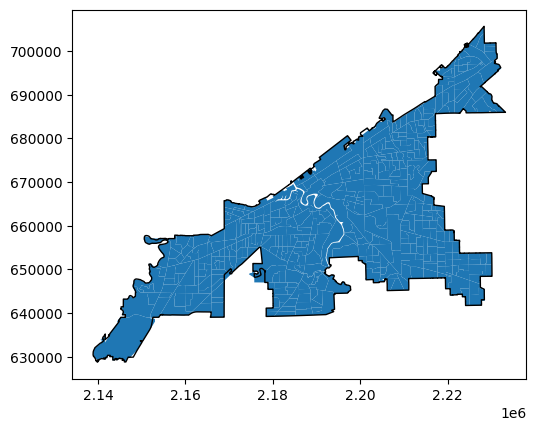

In [37]:
# Let's check how we did. The blue block groups should all be inside our city Boundary shape!
fig, ax = plt.subplots()
cle_bgs.plot(ax=ax)
city_gdf.plot(ax=ax, facecolor='none', edgecolor='black')

In [38]:
# Our primary spatial function, which checks whether a type of amenity is within our buffer distance
# It creates a new column in the given dataframe with a Series of boolean values.
# True = the block group's center is within range, False = the block groups' center is not within range

buffer_distance = 2640 # Half mile in feet
def access_evaluator(access_name, pop_gdf, points_gdf):
    buffer_amenity = points_gdf[points_gdf.Amenity_Type == access_name].buffer(2640).unary_union
    pop_gdf[access_name+"_flag"] = buffer_amenity.intersects(pop_gdf.geometry.representative_point())

In [39]:
# Evaluate each amenity using the function above
for amenity in amenities_gdf.Amenity_Type.unique():
    access_evaluator(amenity, cle_bgs, amenities_gdf)

In [1]:
# Exploring the coverage of all the top 12 most common amenity types
n= 12
top_n = amenities_gdf.Amenity_Type.value_counts(ascending=False).index.to_list()[:n]

# Number of subplots <= (cols x rows)
cols, rows = 3,4  
# Create matplotlib figure with an array of axes to plot on
fig, axs = plt.subplots(nrows=rows, ncols=cols)
# Make it larger so we can fit more map
fig.set_size_inches(12,10)

# Iterate through our most frequent amenities 
count = 0
for irow in range(axs.shape[0]):
    for icol in range(axs.shape[1]):
            amenity = top_n[count]
            cle_bgs[ cle_bgs[amenity+"_flag"] == True].plot(ax=axs[irow][icol])
            amenities_gdf[amenities_gdf.Amenity_Type ==  amenity].plot(ax=axs[irow][icol], color='red', markersize=.3)
            city_gdf.plot(ax=axs[irow][icol], facecolor='none', edgecolor='black')
            axs[irow][icol].set_title(amenity)
            axs[irow][icol].set_axis_off()
            count += 1
fig.suptitle("Block Groups with 1/2 Mile Proximity to Park Amenities", fontweight='bold')

NameError: name 'amenities_gdf' is not defined

Text(0.5, 1.0, 'Proximity to City Park Amenities using Open Data')

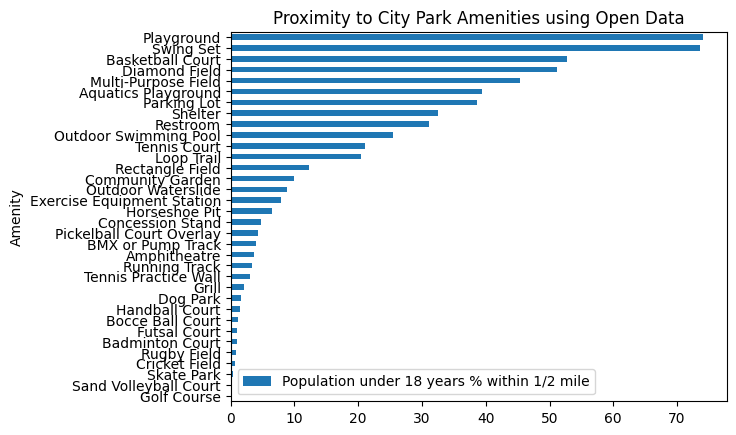

In [41]:
# Let's use these true/false flags to produce summary statistics
# We want to learn about what percent of different populations are within range of these amenities
# To do this we will need to transform our dataset using groupby and aggregations

# Define the list of Census fields we want to iterate through
demographic_groups = ['Population under 18 years']

# Set up a loop that will perform calculations for each column above
out_list = []
for amenity in amenities_gdf.Amenity_Type.unique(): # For each unique amenity
    report_outs = []
    for fld in demographic_groups: # For each demographic group we listed
        try:
            # Sum the number of people in that group that have value True for access to that amenity
            number_covered =cle_bgs.groupby(f'{amenity}_flag').agg({fld:'sum'}).loc[True].iloc[0] 
            # Sum total number of people in that group
            total_possible = cle_bgs[fld].sum()
            # Divide with access over total number
            percent_covered = (100 * number_covered) / total_possible
        except:
            # If there is not True index, that means nobody has access, return 0
            percent_covered = 0
        # Append these figures to the array for this amenity
        report_outs.append(percent_covered)
    # Append this amenity + report outs to the outbound list
    out_list.append([amenity, *report_outs])

# Create a dataframe from the results
# Add % within 1/2 mile to each group column
access_summary = pd.DataFrame(out_list, columns=['Amenity', *[grp + " % within 1/2 mile" for grp in demographic_groups]])


(access_summary.set_index('Amenity') # In order to show at categories on plot
    .sort_values('Population under 18 years % within 1/2 mile') # Order from most to least
    .plot.barh()) # Plot as a bar chart
# Add title to plot
plt.title('Proximity to City Park Amenities using Open Data')

### We now better understand access for Cleveland's under 18 population across all park amenities from the Open Data layer.  

Park amenities like playgrounds are essential, daily places for kids and families to spend their time and get exercise. It makes sense that Cleveland has higher coverage for basic amenities like those. Other amenities are more seasonal and occasional visits, and are not within 1/2 mile of much of the City's under 18 population.

Let's assume we had a goal for 100% coverage of playgrounds within 1/2 mile of all non-adults in Cleveland.

##### **If we had to pick only 1 location, how can we use this data to make the most impactful change?**



### Before we begin, we need to get more familiar with the City's youth population.
It's good practice to learn more about a dataset before visualizing it or conducting analysis. Mapping also requires paying attention to the *geographies* that we're mapping.

For example, consider census tract A that is 10 sq mi. large and has 500 people living in it. And Census tract B is 2 sq. mi wide and also has 500 residents. If we represented the *number of residents* using colors, the tracts will look the same on the map. That might be misleading! Technically, there are 5 times more people in tract B. We recommend considering not only counts of people, but *ratios* and *density* as well to allow true comparisons between areas.

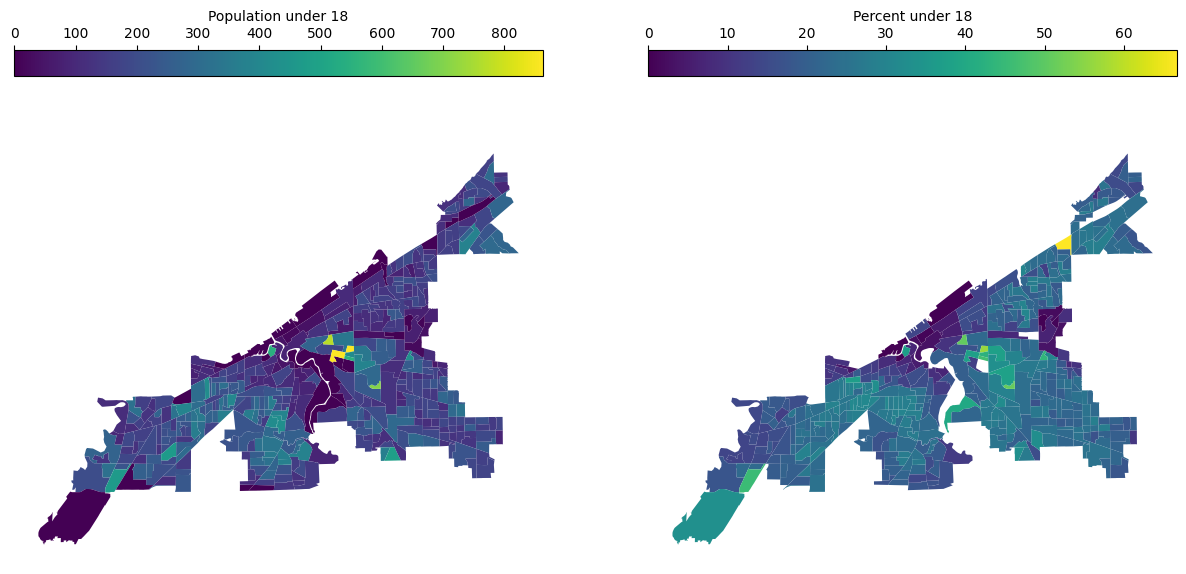

In [42]:
# Set up a two column figure for mapping our under 18 population by block group
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax1 = cle_bgs.plot(ax=ax[0], column='Population under 18 years',
        legend = True,
        legend_kwds={'location': 'top', 'label': 'Population under 18'})
ax2 = cle_bgs.plot(ax=ax[1],
    column='Percent of population under 18 years',
    legend = True,
    legend_kwds={'location': 'top','label': 'Percent under 18'})
for axes in ax:
    axes.set_axis_off()

### Simple Spatial Optimization
#### Looking for the biggest grouping of population under 18 that still doesn't have access to a playground
To find the most effective location (in terms of population under 18), we'll need to find the largest grouping of that population. Our question is, which set of **neighboring** block groups has the **highest** sum of people within that age range? 

In order to do this, we need to define neighboring using a spatial analysis library called `pysal`, which offers functions that check whether shapes touch each other and how.

In [75]:
# Block gruops that don't have access to playground now. These are candidates for assessing optimal location because they can be "gained".
candidate_bgs = cle_bgs[cle_bgs['Playground_flag'] == False]
w_rook = Rook.from_dataframe(candidate_bgs, use_index=True) # Returns an array of neighbors

/home/dns/.pyenv/versions/3.10.12/envs/uai_env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 26 disconnected components.
 There are 12 islands with ids: 6, 94, 100, 135, 161, 185, 199, 313, 339, 358, 359, 1101.
  W.__init__(self, neighbors, ids=ids, **kw)


In [77]:
# This code collects the sum of every grouping identified before. It iterates through the list of index values, subsets the dataframe, and sums the < 18 population field for that subset.
population_dict = {}
for bg in w_rook.neighbors.items():
    block_group_id =bg[0]
    neighboring_ids = bg[1]
    cluster_pop = candidate_bgs.loc[neighboring_ids]['Population under 18 years'].sum()
    # Create new key-value storing that block groups sum
    population_dict[block_group_id] = cluster_pop

In [78]:
# Using the key parameter for max builtin, we can have it fetch each sum from the dictionary (each key). It returns the key of the biggest group per capita.
max_idx = max(population_dict, key=population_dict.get)

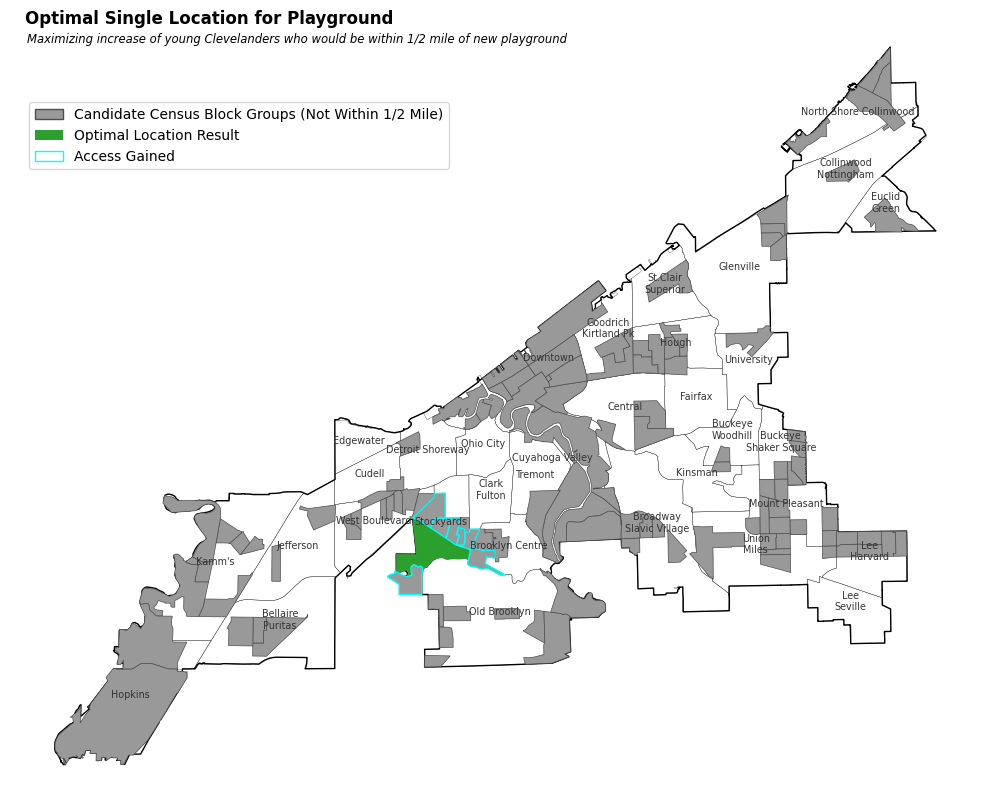

In [100]:
# Build figure and axes with roomy figure size
fig, ax = plt.subplots(1,1, figsize=(10,10))

# Plot neighborhoods
hoods_gdf.plot(ax=ax, facecolor='none', lw=.2)
hoods_gdf.apply(lambda x: ax.annotate(text=x['SPANM'].replace("-", "\n"), xy=x.geometry.centroid.coords[0], ha='center', size='x-small', color='0.2'), axis=1)

# Plot the city boundary for context, remove axes
city_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
ax.set_axis_off()

# Plot all candidate block groups, which didn't have access to a Playground
candidate_bgs.plot(ax=ax, legend=True, fc='0.6', ec='0.3', lw=0.5)
candidate_legend_artist = Rectangle(xy=(0,0), width=200, height=200, fc='0.6', ec='0.3')

# Plot the optimal location. This block group is it! Pass a list with index to filter
candidate_bgs.loc[[max_idx]].plot(ax=ax, facecolor='tab:green')
max_legend_artist = Rectangle(xy=(0,0), width=200, height=200, fc='tab:green')

# Plot the neighboring tracts of the optimal location tract to visually demonstrate the clustering
candidate_bgs.loc[w_rook.neighbors[max_idx]].plot(ax=ax, facecolor='none', edgecolor='cyan')
neighbors_artist = Rectangle(xy=(0,0), width=200, height=200, ec='cyan', fill=None)

# Configure plot titles and build legend with artists
fig.suptitle("Optimal Single Location for Playground", x= 0.03, y=.88, fontweight='bold', ha='left')
ax.set_title("Maximizing increase of young Clevelanders who would be within 1/2 mile of new playground", ha='left', x= 0.018, y =.95, fontstyle='italic', fontsize='small')
ax.legend([candidate_legend_artist, max_legend_artist, neighbors_artist],
          ["Candidate Census Block Groups (Not Within 1/2 Mile)", "Optimal Location Result", "Access Gained"],
          loc=(0.02,.8))
fig.tight_layout()

### Spatial Optimizer Function in `cledatatoolkit`

This type of "most efficient location" problem comes up often in service and operations planning. We provide a quick, one-step version of the algorithm in our Python package, `cledatatoolkit`. You can call it via `optimal_single_location()` in the `spatial` module. This script is provided as an aid for location planning and does not claim to provide final recommendations on the _best_ location. There are many other factors beyond spatial proximity that will influence any decision!

Check the README documentation in the [cledatatoolkit](https://github.com/City-of-Cleveland/cledatatoolkit) homepage on GitHub to learn more about its parameters and results.

In [49]:
# Calling optimal single location with playgrounds as input, and census blockgroup data as targeted areas
optimal_results = cdt.spatial.optimal_single_location(
                            poi_gdf = amenities_gdf[amenities_gdf.Amenity_Type == "Playground"],
                            targeted_areas = cle_bgs,
                            weight_col = "Population under 18 years",
                            search_distance = 2640)
# "optimal_idx" is the original index of the identified optimum
# "added" is a list of inxexes of all areas that gain access
# "total_gain" shows you the total gain of people, things, etc. from your weight_col
optimal_results

{'optimal_idx': [73],
 'added': [45, 67, 68, 69, 71, 72, 73, 74, 76, 77, 73],
 'total_gain': 3062}

You can pass a result list to a dataframe .loc() as needed. Use "optimal_idx" index values to map the specific optimum location. Use "added" indexes to show all newly served tracts, including the optimum. The "total_gain" tells you how many people gained access based on this optimal spot.

In [50]:
# Filter the optimal geography using the results on `optimal_single_location`
cle_bgs.loc[optimal_results['optimal_idx']]

,Object ID,Geographic Identifier,Area of Land (Square Meters),Area of Water (Square Meters),Current latitude of the internal point,Current longitude of the internal point,Name,State,County,Total Population,...,Sand Volleyball Court_flag,Running Track_flag,Loop Trail_flag,Grill_flag,Amphitheatre_flag,Concession Stand_flag,Restroom_flag,Handball Court_flag,Swing Set_flag,Pickelball Court Overlay_flag
73,216538,390351053004,139613,0,+41.4605113,-81.7182721,Block Group 4,Ohio,Cuyahoga County,818,...,False,False,False,False,False,False,False,False,False,False
